In [1]:
import pandas as pd
import datetime
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Задание 1

Retention – один из самых важных показателей в компании. Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

предварительный анализ данных

In [2]:
reg = pd.read_csv('problem1-reg_data.csv', sep=';')  # читаем файл с регистрациями
reg['reg_ts'] = pd.to_datetime(reg['reg_ts'], unit="s").dt.date  # переводим дату к читаемому формату и убираем часы
reg['reg_ts'] = pd.to_datetime(reg['reg_ts'])  # приводим дату к формату даты
print(reg.shape)
reg.head(5)

(1000000, 2)


,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


In [3]:
auth = pd.read_csv('problem1-auth_data.csv', sep=';')  # читаем файл со входами
auth['auth_ts'] = pd.to_datetime(auth['auth_ts'], unit="s").dt.date  # переводим дату к читаемому формату и убираем часы
auth['auth_ts'] = pd.to_datetime(auth['auth_ts'])  # приводим дату к формату даты
print(auth.shape)
auth.head(5)

(9601013, 2)


,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


In [4]:
print(reg.isna().sum())
print(auth.isna().sum())

reg_ts    0
uid       0
dtype: int64
auth_ts    0
uid        0
dtype: int64


пропусков в данных нет

In [5]:
print(reg.nunique())
print(auth.nunique())

reg_ts       5110
uid       1000000
dtype: int64
auth_ts       6169
uid        1000000
dtype: int64


в таблице входов находится столько же пользователей, что и в таблице регистраций

In [6]:
print(len(reg) - len(reg.drop_duplicates()))
print(len(auth) - len(auth.drop_duplicates()))

0
0


дубликатов в данных нет

После предварительного анализа данных можно сделать вывод, что данные корректны и их можно использовать для расчета retention

Введите начальную дату в формате гггг-мм-дд 2020-05-08
Введите количество дней 14


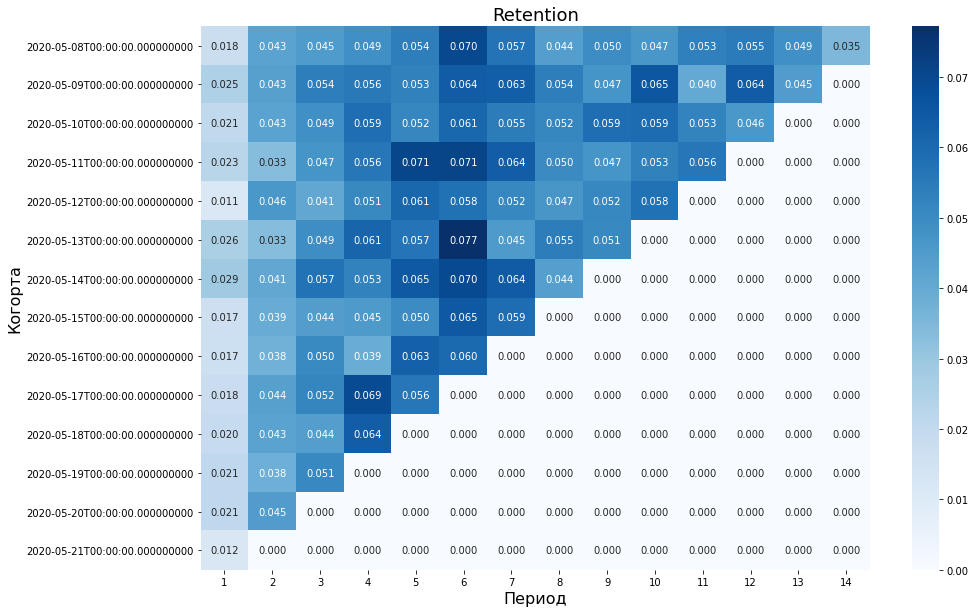

In [7]:
def retention(start=input("Введите начальную дату в формате гггг-мм-дд "), delta=input("Введите количество дней ")):
    try:
        start = datetime.datetime.strptime(start, '%Y-%m-%d')
    except ValueError:
        start = 'x'
    try:
        delta = datetime.timedelta(days=int(delta))
    except ValueError:
        delta = 'x'
    if start == 'x' or delta == 'x':
        return print('что-то введено не так, проверьте формат')
    elif start > datetime.datetime.now():
        return print('кажется, этот день еще не наступил')
    else:
        """читаем файл с регистрациями"""
        reg = pd.read_csv('problem1-reg_data.csv', sep=';')
        """переводим дату к читаемому формату и убираем часы"""
        reg['reg_ts'] = pd.to_datetime(reg['reg_ts'], unit="s").dt.date
        """приводим дату к формату даты"""
        reg['reg_ts'] = pd.to_datetime(reg['reg_ts']) 
        
        if ~reg['reg_ts'].isin([start]).any():
            return print('в этот день никто не зарегистрировался:(')
        else:
            """считаем для каждой когорты количество пользователей"""
            reg = reg.merge(reg.groupby(['reg_ts'], as_index=False) 
                               .agg({'uid': 'nunique'}) 
                               .rename(columns={'uid': 'пользователей в когорте'}),
                            how='inner') 

            """читаем файл со входами"""
            auth = pd.read_csv('problem1-auth_data.csv', sep=';') 
            """переводим дату к читаемому формату и убираем часы"""
            auth['auth_ts'] = pd.to_datetime(auth['auth_ts'], unit="s").dt.date 
            """приводим дату к формату даты"""
            auth['auth_ts'] = pd.to_datetime(auth['auth_ts']) 

            """сводим все в одну табличку"""
            df = auth.merge(reg, how='outer') 
            """считаем количество дней между регистрацией"""
            """и повторным входом для каждого посещения каждого пользователя"""
            df['delta'] = df.auth_ts - df.reg_ts 
            df['delta'] = df['delta'].dt.days
            
            """считаем количество вернувшихся пользователей в каждой когорте"""
            df_gr = df.groupby(['reg_ts', 'auth_ts', 'delta', 'пользователей в когорте'], as_index=False) \
                .agg({'uid': 'nunique'}) \
                .rename(columns={'uid': 'повторили вход'}) 
            """считаем ретеншн"""
            df_gr['retention'] = df_gr['повторили вход'] / df_gr['пользователей в когорте'] 
            
            """исключаем ретеншн нулевого дня и сортируем таблицу"""
            df_gr = df_gr.query("delta != 0").sort_values(['reg_ts', 'auth_ts'])
            
            """фильтруем отобранные даты"""
            end = start + delta
            end
            df_gr = df_gr.query("reg_ts >= @start & reg_ts <=@end & auth_ts <= @end") 
            """строим сводную таблицу"""
            retent = df_gr.pivot(columns='delta', index='reg_ts', values='retention').fillna(0) 
            
            """рисуем график"""
            plt.figure(figsize=(15, 10))
            ax = sns.heatmap(retent, annot=True, fmt='.3f', cmap='Blues')
            plt.xlabel('Период', size=16)
            plt.ylabel('Когорта', size=16)
            plt.title('Retention', size=18)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

            plt.show()
        
    
retention()

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [8]:
base_url = 'https://getfile.dokpub.com/yandex/get/'

url_ab = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

d = pd.read_csv(base_url + url_ab, sep=';')
d.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


проведем предварительный анализ данных

In [9]:
d.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

пропусков в данных нет

In [10]:
len(d) - len(d.drop_duplicates(['user_id']))

0

дубликатов в данных нет. Если бы они были, мы могли бы предположить, что данные записаны по транзакциям и тогда доход с одного пользователя необходимо просуммировать. Так же видим, что пользователи разбиты на группы, никто не попал в две разные группы одновременно. Можем считать, что данные корректны и переходить к анализу результатов теста

проверим наши данные на нормальность

H0 -- данные имеют нормальное распределение

H1 -- иначе

In [11]:
print(stats.normaltest(d.query("testgroup == 'a'").revenue))
print(stats.normaltest(d.query("testgroup == 'b'").revenue))

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)
NormaltestResult(statistic=326622.39540856465, pvalue=0.0)


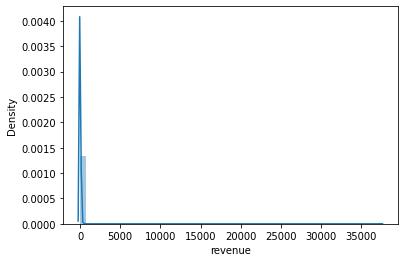

In [12]:
sns.distplot(d.query("testgroup == 'a'").revenue)

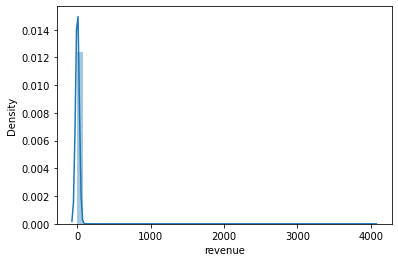

In [13]:
sns.distplot(d.query("testgroup == 'b'").revenue)

p-value = 0, данные не имеют нормальное распределение, однако за счет объема выборок это условие не является обязательным, важно, чтобы были нормально распределены выборочные средние, при больших выборках это верно всегда.

тестируем равенство дисперсий

H0 -- две группы имеют равные дисперсии

H1 -- иначе

In [14]:
stats.levene(d.query("testgroup == 'a'").revenue, 
             d.query("testgroup == 'b'").revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

p-value = 0.53, не отвергаем нулевую гипотезу о равенстве дисперсий. Значит можем применять t-test для оценки равенства средних значений в выборках

рассчитаем средний чек в каждой группе

In [15]:
d.groupby('testgroup').agg({'revenue': 'mean'})

,revenue
testgroup,
a,25.413720
b,26.751287


рассчитаем средний чек среди платящих в каждой группе

In [16]:
d.query("revenue > 0").groupby('testgroup').agg({'revenue': 'mean'})

,revenue
testgroup,
a,2663.998444
b,3003.658172


в обоих случаях средний чек в группе b выше. Необходимо проверить, являются ли эти различия статистически значимыми

H0 -- Средний чек для первого набора не отличается от среднего чека для второго набора

H1 -- иначе

In [17]:
stats.ttest_ind(d.query("testgroup == 'a'").revenue, 
                d.query("testgroup == 'b'").revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

p-value = 0.53, на 5% уровне значимости не отвергаем гипотезу о равенстве математических ожиданий -> должны сделать вывод, что различия не значимы -> ARPU на одном уровне, нет лучшего варианта

посмотрим так ли это для платящей аудитории

In [18]:
stats.ttest_ind(d.query("testgroup == 'a' & revenue > 0").revenue, 
                d.query("testgroup == 'b' & revenue > 0").revenue)

Ttest_indResult(statistic=-1.5917100176862002, pvalue=0.11153459157259504)

p-value = 0.11, на 5% уровне значимости не отвергаем гипотезу о равенстве математических ожиданий -> должны сделать вывод, что различия не значимы -> ARPU на одном уровне, нет лучшего варианта

посчитаем конверсию в покупку

In [19]:
d['purchase'] = np.where(
    d['revenue'] > 0, 1, 0)
d

,user_id,revenue,testgroup,purchase
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0
...,...,...,...,...
404765,404766,0,a,0
404766,404767,0,b,0
404767,404768,231,a,1
404768,404769,0,a,0


In [20]:
d.groupby('testgroup').agg({'purchase': 'mean'})

,purchase
testgroup,
a,0.009540
b,0.008906


конверсия в покупку получилась выше в группе а, проверим можно ли считать это различие статистически значимым

H0 -- Конверсия в покупку для первого набора не отличается от конверсии в покупку для второго набора

H1 -- иначе

In [21]:
stats.ttest_ind(d.query("testgroup == 'a'").purchase,
                d.query("testgroup == 'b'").purchase)

Ttest_indResult(statistic=2.1080348595227503, pvalue=0.03502858727991682)

p-value = 0.35, на 5% уровне значимости отвергаем гипотезу о равенстве математических ожиданий -> должны сделать вывод, что первый набор лучше, поскольку дает бОльшую конверсию в покупку -> для привлечения платящих пользователей затрачивается меньше ресурсов (при этом помним, что ARPU не показал статистически значимых различий).

таким образом стоит оставить текущее акционное предложение (набор a) и не предлагать пользователям второе предложение (набор b)

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

__________________________________________________________________________________________________

Вовлеченность = количество игроков, принявших участие / количество активных игроков (например тех, кто играл в нашу игру в этом месяце)

С помощью этого показателя мы поймем какой доле нашей аудитории было интересно тематическое событие


Доходимость = количество игроков, прошедших событие / количество игроков, начавших прохождение события

С помощью этого показателя мы сможем оценить сложность события, а так же то, насколько сохранился интерес пользователей к событию после того, как они попробовали принять участие в нем

Скорее всего событие подразумевает набор более мелких заданий, за каждое из которых игрок может получить награду или % прохождения события, за которое игрок получает награду.
В таком случае интересующей нас метрикой может быть
среднее количество наград = количество полученных наград / количество игроков, начавших прохождение события

Средний процент прохождения = сумма процентов прохождения всех принявших участие игроков / количество игроков, начавших прохождение события

Уровень (процент прохождения), на котором чаще всего отваливались игроки = уровень(макс (количество игроков, которые после данного уровня не вернулись в событие))

Эти метрики позволят оценить сложность события, чем ниже средний %, тем сложнее уровни в событии

Уровень, на котором отвалилось больше всего игроков покажет самый сложный уровень в событии

На основе этих показателей можно строить дальнейшие события, упрощая или усложняя уровни

Метрики, прямо указывающие на доход:

ARPU (средний чек)
Доля платящих пользователей
Суммарный доход за время события

Данные метрики стоит рассматривать в динамике относительно прошедших событий, чтобы увидеть какое из них прошло более успешно, какое менее

В целом, набор метрик не должен меняться от события к событию, чтобы мы могли их сравнивать между собой. В данном случае точно изменятся значения метрик, стоит ожидать, что доходимость станет меньше за счет откатов, кто-то просто не успеет дойти, кому-то надоест возвращаться назад. Чтобы подготовиться к таким моментам заранее, стоит продумать тонкости данной механики, например, что может сделать пользователь чтобы не откатываться назад? Возможно 1-2 бесплатные возможности повторить только проваленный уровень. Это позволит игроку не упасть в отчаяние от откатов и даст возможность нам получить доп. выручку за счет пользователей, которые будут готовы заплатить за отмену отката.